In [2]:
import pandas as pd
import numpy as np

In [6]:
train = pd.read_csv('/content/Constraint_English_Train - Sheet1.csv')
test= pd.read_csv('/content/Constraint_English_Test - Sheet1.csv')
test1=pd.read_csv('/content/english_test_with_labels - Sheet1.csv')
test['label']=test1['label']
print(train)
print(test)
print(test1)

        id                                              tweet label
0        1  The CDC currently reports 99031 deaths. In gen...  real
1        2  States reported 1121 deaths a small rise from ...  real
2        3  Politically Correct Woman (Almost) Uses Pandem...  fake
3        4  #IndiaFightsCorona: We have 1524 #COVID testin...  real
4        5  Populous states can generate large case counts...  real
...    ...                                                ...   ...
6415  6416  A tiger tested positive for COVID-19 please st...  fake
6416  6417  ???Autopsies prove that COVID-19 is??� a blood...  fake
6417  6418  _A post claims a COVID-19 vaccine has already ...  fake
6418  6419  Aamir Khan Donate 250 Cr. In PM Relief Cares Fund  fake
6419  6420  It has been 93 days since the last case of COV...  real

[6420 rows x 3 columns]
        id                                              tweet label
0        1  Our daily update is published. States reported...  real
1        2             

In [7]:
df=train.filter(['label','tweet'], axis=1)
df_test=test.filter(['label','tweet'],axis=1)

In [8]:
#removing @ and #
def punc(df):
    df['tweet'] = df['tweet'].str.replace('[#@()]','')
    print(df)

In [9]:
punc(df)
punc(df_test)

     label                                              tweet
0     real  The CDC currently reports 99031 deaths. In gen...
1     real  States reported 1121 deaths a small rise from ...
2     fake  Politically Correct Woman Almost Uses Pandemic...
3     real  IndiaFightsCorona: We have 1524 COVID testing ...
4     real  Populous states can generate large case counts...
...    ...                                                ...
6415  fake  A tiger tested positive for COVID-19 please st...
6416  fake  ???Autopsies prove that COVID-19 is??� a blood...
6417  fake  _A post claims a COVID-19 vaccine has already ...
6418  fake  Aamir Khan Donate 250 Cr. In PM Relief Cares Fund
6419  real  It has been 93 days since the last case of COV...

[6420 rows x 2 columns]
     label                                              tweet
0     real  Our daily update is published. States reported...
1     fake             Alfalfa is the only cure for COVID-19.
2     fake  President Trump Asked What He Wou

In [10]:
import fastai
from fastai import *
from fastai.text import * 
from functools import partial
import io
import os

In [11]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df, valid_df = df_test, path = "")

/usr/local/lib/python3.6/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [12]:
data_lm.show_batch

<bound method DataBunch.show_batch of TextLMDataBunch;

Train: LabelList (6420 items)
x: LMTextList
xxbos xxmaj the xxup cdc currently reports xxunk deaths . xxmaj in general the xxunk in death counts between different sources are small and xxunk . xxmaj the death toll stands at roughly 1 xxrep 5 0 people today .,xxbos xxmaj states reported xxunk deaths a small rise from last xxmaj tuesday . xxmaj southern states reported xxunk of those deaths . https : / / t.co / xxunk,xxbos xxmaj politically xxmaj correct xxmaj woman xxmaj almost xxmaj uses xxmaj pandemic as xxmaj excuse xxmaj not to xxmaj xxunk xxmaj plastic xxmaj bag https : / / t.co / xxunk coronavirus nashville,xxbos indiafightscorona : xxmaj we have xxunk xxup covid testing laboratories in xxmaj india and as on 25th xxmaj august 2020 xxunk tests have been done : profbhargava xxup dg xxup icmrdelhi staysafe indiawillwin https : / / t.co / xxunk,xxbos xxmaj populous states can generate large case counts but if you look at the new 

In [13]:
#loading AWD_LSTM language model
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-02
Min loss divided by 10: 5.01E-02


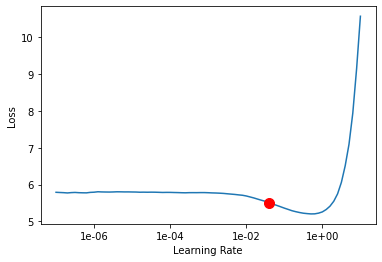

In [14]:
#to find the optimal learning rate
learn.lr_find(start_lr=1e-8, end_lr=1e2)
learn.recorder.plot(suggestion = True)

In [15]:
#fitting the data
learn.fit_one_cycle(2, 5e-2)
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time
0,3.977278,3.301267,0.407288,00:09
1,3.140021,3.101866,0.432612,00:10


In [16]:
learn.fit_one_cycle(3, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.740031,3.063568,0.438650,00:13
1,2.451829,2.898438,0.470949,00:13
2,1.735070,2.986692,0.480469,00:13


In [17]:
learn.freeze_to(-1)
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 7.59E-03
Min loss divided by 10: 3.31E-05


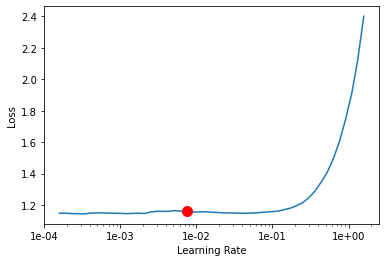

In [18]:
learn.recorder.plot(skip_start=40, suggestion=True)

In [19]:
learn.fit_one_cycle(3, slice(1e-2/(2.6**4), 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,1.183929,3.040507,0.479788,00:11
1,1.108709,3.078499,0.481217,00:11
2,0.990203,3.085048,0.482467,00:11


In [20]:
learn.freeze_to(-2)
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.92E-04
Min loss divided by 10: 1.32E-03


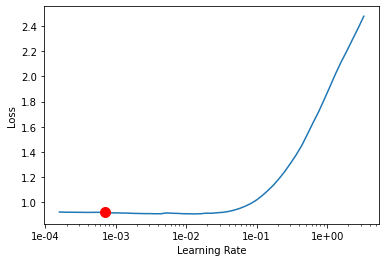

In [21]:
learn.recorder.plot(skip_start=40, suggestion=True)

In [22]:
learn.fit_one_cycle(3, slice(6e-3/(2.6**4), 6e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.945442,3.181781,0.479710,00:11
1,0.921708,3.227679,0.480826,00:11
2,0.838625,3.247687,0.481083,00:12


In [23]:
#save the encoder model
learn.save_encoder('my_encoder')

In [24]:
# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df, valid_df = df_test, vocab=data_lm.train_ds.vocab, bs=32)

/usr/local/lib/python3.6/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [25]:
#building classifier
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=[accuracy, FBeta(beta=1)])

#loading the saved encoder
learn.load_encoder('my_encoder')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (6420 items)
x: TextList
xxbos xxmaj the xxup cdc currently reports xxunk deaths . xxmaj in general the xxunk in death counts between different sources are small and xxunk . xxmaj the death toll stands at roughly 1 xxrep 5 0 people today .,xxbos xxmaj states reported xxunk deaths a small rise from last xxmaj tuesday . xxmaj southern states reported xxunk of those deaths . https : / / t.co / xxunk,xxbos xxmaj politically xxmaj correct xxmaj woman xxmaj almost xxmaj uses xxmaj pandemic as xxmaj excuse xxmaj not to xxmaj xxunk xxmaj plastic xxmaj bag https : / / t.co / xxunk coronavirus nashville,xxbos indiafightscorona : xxmaj we have xxunk xxup covid testing laboratories in xxmaj india and as on 25th xxmaj august 2020 xxunk tests have been done : profbhargava xxup dg xxup icmrdelhi staysafe indiawillwin https : / / t.co / xxunk,xxbos xxmaj populous states can generate large case counts but if you look at the new cases per million toda

epoch,train_loss,valid_loss,accuracy,f_beta,time


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 6.31E-02


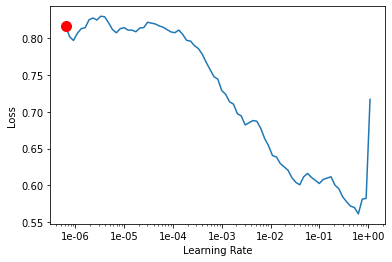

In [26]:
learn.lr_find()
learn.recorder.plot(suggestion=True)


In [27]:
learn.fit_one_cycle(3, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.404714,0.186593,0.934579,0.937556,00:09
1,0.322223,0.158304,0.940654,0.942036,00:10
2,0.263145,0.150575,0.949533,0.953084,00:10


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

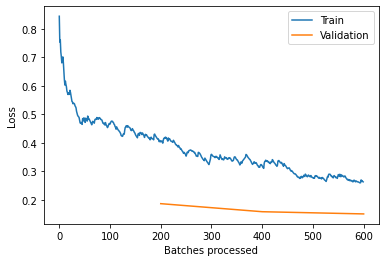

In [28]:
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,f_beta,time


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 3.31E-03


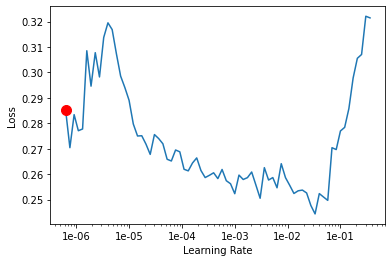

In [29]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [30]:
learn.freeze_to(-2) # unfreeze last 2 layers
learn.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.321553,0.166150,0.948131,0.950380,00:12
1,0.217585,0.120190,0.955607,0.957983,00:12


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

epoch,train_loss,valid_loss,accuracy,f_beta,time


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 3.63E-04


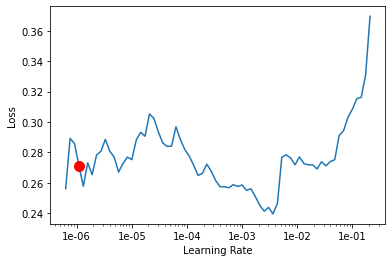

In [31]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [32]:
learn.freeze_to(-3)
learn.fit_one_cycle(2, slice(5.3e-3/(2.6**4),5.31e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.212488,0.114993,0.962150,0.963726,00:18
1,0.138479,0.092293,0.965888,0.967799,00:18


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [33]:
learn.freeze_to(-4) # unfreeze last 4 layers
learn.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))
learn.freeze_to(-5) # unfreeze last 5 layers
learn.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

# Unfreezing all the layers and training
learn.unfreeze() # unfreze all
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.185921,0.108063,0.967290,0.968525,00:22
1,0.087096,0.086486,0.970093,0.971403,00:22


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.106825,0.097299,0.971028,0.972687,00:24
1,0.056005,0.088768,0.974766,0.976191,00:23


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.052241,0.078849,0.976168,0.977424,00:21
1,0.033440,0.081766,0.978505,0.979592,00:22
2,0.032579,0.077688,0.980374,0.981317,00:24


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [34]:
#getting the predictions
preds, targets = learn.get_preds()
predictions = np.argmax(preds, axis = 1)

In [35]:
pd.crosstab(predictions, targets)

col_0,0,1
row_0,,
0,995,17
1,25,1103


In [36]:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score
cm=confusion_matrix(predictions,targets)
print(cm)
score = accuracy_score( predictions, targets)
print(score)

[[ 995   17]
 [  25 1103]]
0.9803738317757009


In [37]:
df=pd.DataFrame({'id': test.id, 'label': predictions})
df.label = df.label.apply({0:'fake', 1: 'real'}.get)
df

,id,label
0,1,real
1,2,fake
2,3,fake
3,4,real
4,5,real
...,...,...
2135,2136,real
2136,2137,fake
2137,2138,real
2138,2139,real


In [ ]:
#df.to_csv('ULMFit_submissionn.csv',index=False)

In [ ]:
#from google.colab import files
#files.download("ULMFit_submissionn.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>